In [14]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from math import sqrt
from numpy.ma import count

In [15]:
# Carregando os dados
data = pd.read_csv('../dataset/dados_datatran2022.csv',encoding='iso-8859-1',sep=';')

In [ ]:
#Conhecendo como está estruturado o nosso dataset
data.info()

In [ ]:
#Analisando uma amostra, 20 primeiras linhas do dataset
data.head(20)

In [16]:
#Limpando os valores nulos / vazios para que estão na coluna 'br'
df = data

df.dropna(axis=0, subset=['br'],inplace=True)

In [17]:
#Fazendo uma copia do dataset original
df = data

#Filtrando as colunas que vou trabalhar
df = df.filter(["fase_dia","sentido_via","condicao_metereologica","tipo_pista","tracado_via","mortos",'feridos','veiculos'])

#Alterando o tipo das colunas
df["fase_dia"] = df['fase_dia'].astype('object')
df["sentido_via"] = df['sentido_via'].astype('object')
df["condicao_metereologica"] = df['condicao_metereologica'].astype('object')
df["tipo_pista"] = df['tipo_pista'].astype('object')
df["tracado_via"] = df['tracado_via'].astype('object')

#Fazendo a 'dummerização' para determinadas colunas
df = pd.get_dummies(df,columns=['fase_dia',"sentido_via",'condicao_metereologica','tipo_pista','tracado_via'],drop_first=False)

In [18]:
# Divide por classes
count_class_0, count_class_1 = df.mortos.value_counts()
df_class_0 = df[df['mortos'] == 0]
df_class_1 = df[df['mortos'] == 1]
df_class_0 = df_class_0.sample(count_class_0)
df_class_1 = df_class_1.sample(count_class_1)

In [19]:
# Separando os dados de entrada (X) e saída (y)
X = df.drop('mortos', axis=1)
y = df['mortos']

mortos
0    3718
1    3718
Name: count, dtype: int64


C:\Users\diegosilva\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


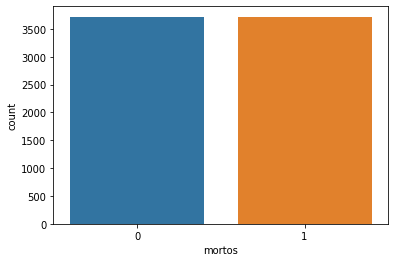

In [20]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X, y)
# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())
# plotar a nova distribuição de classes
sns.countplot(y_res);

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [22]:
scale_pos_weight = sqrt(df_class_0.mortos.count()/df_class_1.mortos.count())
scale_pos_weight

3.686657973629224

In [23]:
# Create an XGBoost classifier
model = xgb.XGBClassifier(random_state = 42, n_jobs = 1, scale_pos_weight = scale_pos_weight, n_estimators = 372)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8862742688621282


In [ ]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
# Cálculo dos valores de TPR e FPR para diferentes valores de limiar de classificação
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [ ]:
# Cálculo da AUC da curva ROC
roc_auc = roc_auc_score(y_test, y_prob)

In [ ]:
# Plotagem da curva ROC
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred)

In [ ]:
# Plotagem da matriz de confusão usando a biblioteca seaborn
sns.heatmap(cm, annot=True, cmap='BrBG', fmt=".0f")
plt.title('Matriz de confusão do modelo')
plt.xlabel('Classes previstas')
plt.ylabel('Classes verdadeiras')
plt.show()

In [ ]:
#RESULTADOS COM RANDOM FOREST

In [ ]:
# Criação e treinamento do modelo de Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rfc.fit(X_train, y_train)

In [ ]:
# Realização das previsões no conjunto de teste
y_pred = rfc.predict(X_test)

In [ ]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

In [ ]:
# Avaliação do modelo
accuracy = rfc.score(X_test, y_test)
print('Acurácia do modelo: {:.2f}%'.format(accuracy*100))

In [ ]:
# Cálculo do recall
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall do modelo: {:.2f}%'.format(recall*100))

In [ ]:
# Cálculo da precisão
precision = precision_score(y_test, y_pred, average='weighted')
print('Precisão do modelo: {:.2f}%'.format(precision*100))

In [ ]:
# Cálculo do F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1-score do modelo: {:.2f}%'.format(f1*100))

In [ ]:
y_prob = rfc.predict_proba(X_test)[:, 1]

In [ ]:
# Cálculo dos valores de TPR e FPR para diferentes valores de limiar de classificação
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

In [ ]:
# Cálculo da AUC da curva ROC
roc_auc = roc_auc_score(y_test, y_prob)

In [ ]:
# Plotagem da curva ROC
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred)

In [ ]:
# Plotagem da matriz de confusão usando a biblioteca seaborn
sns.heatmap(cm, annot=True, cmap='BrBG', fmt=".0f")
plt.title('Matriz de confusão do modelo')
plt.xlabel('Classes previstas')
plt.ylabel('Classes verdadeiras')
plt.show()